# MLP: Multi Layer Perceptron to our Character level language model

[Paper Implementation: A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Use full link: 
* [PyTorch internals](https://blog.ezyang.com/2019/05/pytorch-internals/)

In [4]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

## The main idea:


A goal of statistical language modeling is to learn the joint probability function of sequences of
words in a language. -> this is intrinscially difficult because of the curse of dimensionality as our Matrix N will keep getting larger and larger 

The paper propose to fight the curse of dimensionality by learning a distributed representation for words which allows each training sentenace to inform the model about an exponential number of semantically neighboring sentences 

The model learns simultaneously 
1. a distributed representation for each word along with 
2. the probability function for word sequences, expressed in terms of these representation 

**What is a Distributed Representation for Each Word?**

In traditional language models (like n-grams), words are treated as discrete symbols. Each word is typically assigned a unique index, meaning the model has no inherent understanding of the relationships between words. For example:
*	“dog” → Index 1023
*	“cat” → Index 453
*	“apple” → Index 7890

This representation is one-hot encoding, where each word is represented as a long vector with a single 1 at the corresponding index and 0s elsewhere. However, this approach has two major drawbacks:
*	It is sparse (high-dimensional vectors with mostly zeros).
*	It lacks semantic relationships (e.g., “dog” and “cat” are treated as completely unrelated).

How Distributed Representations Solve This Problem

Instead of using one-hot vectors, the neural model assigns each word a continuous, dense vector representation in a lower-dimensional space. This is known as word embeddings.

For example, instead of:
`dog → [0, 0, 0, 1, 0, 0, ..., 0]  (one-hot vector of size 100,000)`

we only have 
`dog → [0.8, -1.2, 0.3, 0.5, ...]  (dense vector of size 300)`

These vectors capture semantic similarities:
*	“dog” and “cat” will have similar vector representations because they belong to the same category (animals).
*	“dog” and “car” will have very different vectors because they are unrelated concepts.

____________________
Key Idea
*	Each word is mapped to a continuous vector space, where similar words have similar representations.
*	These embeddings are learned during training and allow the model to generalize better to unseen word sequences.


**Probability Function for Word Sequences Using These Representations**

Once we have dense word embeddings, we can define a probability function for predicting the next word in a sequence.

*Traditional n-gram Probability Function*

In an n-gram model, the probability of a word sequence is defined as:

$$P(w_t | w_{t-1}, w_{t-2}, …, w_{t-n+1})$$

Where each $w_t$ is a word from the vocabulary, and probabilities are learned based on counting occurrences in a corpus.

*Neural Probability Function*

Instead of relying on discrete word occurrences, the neural probabilistic model defines the probability function in terms of the learned word representations:

$$P(w_t | w_{t-1}, w_{t-2}, …, w_{t-n+1}) = f(\textbf{v}{w{t-1}}, \textbf{v}{w{t-2}}, …, \textbf{v}{w{t-n+1}})$$

where:
*	$\textbf{v}_{w}$ is the word embedding of word w.
* 	f is a neural network that learns to predict the next word given its context.

Instead of looking up fixed probability tables (as in n-grams), the model learns a smooth function that can generalize to unseen sequences.

Example: Predicting the Next Word

Let’s say our training corpus contains:
* 	“The cat sat on the mat.”
* 	“The dog lay on the mat.”

If the model encounters the incomplete sentence “The rabbit jumped on the ___”, traditional models might struggle because they haven’t seen “rabbit” before.

However, a neural probabilistic model has distributed representations where “rabbit” has a similar vector to “cat” and “dog,” allowing it to infer that “mat” is still a likely next word.

________________________

*Key Takeaways*
1.	Distributed Representations:
	*	Instead of treating words as discrete symbols, the model represents each word as a dense, continuous vector.
	*	This allows words with similar meanings to have similar representations, helping generalization.
2.	Probability Function in Terms of Representations:
	*	Instead of counting word sequences, the model learns a function that predicts the next word based on the embeddings of previous words.
	*	This function is implemented as a neural network, which can generalize to unseen sequences.
3.	Advantage Over Traditional Models:
	*	The neural model avoids the curse of dimensionality by reducing reliance on explicit probability tables.
	*	It learns semantic relationships between words, making it more robust to data sparsity.

## Data loading

In [5]:
words = open('name.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
# Look up for characters 
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}

In [7]:
# Creating the dataset 
X ,Y = [], []

# this is context length: how many character do we take to predict the next
block_size = 3 

for w in words[:5]:
    
    print(w)
    # Setting the index for SOS 
    context = [0] * block_size
    
    # loop through all the chs in w with EOS as '.'
    for chs in w + '.':
        ix = stoi[chs]
        X.append(context) # already known 
        Y.append(ix) # following/next character 

        print(f"{''.join(itos[i] for i in context)} -----> {itos[ix]}")
        # updating the context 
        context = context[1:] + [ix]

# Converting to tensor
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
# look up table for the neural net
# in the paper they have embedded a vocab of 17000 words to as small as 17000, 300 
# we will try to embedded it into 27, 2 

# randomly intiallized the C 
C = torch.randn((27, 2)) 


In [10]:
# lets try to embedded the integer 6 (this will be index 5 as indexing in python starts at 0)
# the embedding we have at index 5 is 
C[5]

tensor([1.2189, 0.2867])

In [11]:
# Earlier we were using one-hot encoding to create a new vector
# if we do the same for int 5 we will have a vector of size 27 with 1 at index 5 and rest everything as 0 
# and when we multiply the same with C we will get the same result as indexing at C[5]
# instead of doing one-hot encoding and doing matrix multiplication we can just index C 

F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([1.2189, 0.2867])

In [12]:
X[0], C[0], C[X[0]].shape

(tensor([0, 0, 0]), tensor([-0.6964, -1.0027]), torch.Size([3, 2]))

In [13]:
C[X].shape

torch.Size([32, 3, 2])

In [14]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [15]:
# Creating the hidden layer 
W1 = torch.randn((6, 100) )
b1 = torch.randn(100)


# Now what we will be doing is emb @ W1 + b1 but this will through the error as 
# our embedding are of the shape 32, 3, 2 and W1 is 6, 100 
# to solve this we can use pytoch method torch.cat -> it takes a sequence of tensor and concat them for the given dim

# for all the examples give me the embedding for the 1st character in the context 
# as per the image in the paper these are the output from the first layer for neuron 0, 1, 2
# emb[:, 0, :] , emb[:, 1, :], emb[:, 2, :] each one of them will of shape (32, 2)
# representing the first character, second character, third character and each character represented by vector of size 2(embedding)
# concat them at dim 1 we will get the 32, 6


In [16]:
torch.cat((emb[:, 0, :] , emb[:, 1, :], emb[:, 2, :]), 1).shape

# but if we increase the block size then we will have to update the above code again 
# instead of this we can use torch.unbind -> this removes a tensor dimenssion 
# so we will remove the dim 1 and create a tuple of 3(based on the input tensor) tensor of shape 32,2  
# and then concat them together at dim 1 to get 32, 6

torch.Size([32, 6])

In [17]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [18]:
# the better option view() : gives a temporary view of the shape we want make no changes in the input tensor 
emb.view(-1, 6).shape, emb.view(-1, 6).dtype

(torch.Size([32, 6]), torch.float32)

In [19]:
h = torch.tanh((emb.view(-1, 6) @ W1 + b1))
h.shape, h.dtype, h[:1]

# emb.view(-1, 6) @ W1 -> (32, 100)
# b1 -> 100 
# when we are adding the broadcasting will take place 
# braoadcasting will move the 100 to right to align with W1's 100 and create a fake dimenssion in b1 
# 32 , 100
# 1 ,  100
# and for each of the 32 rows the b1 will be copied and added 

(torch.Size([32, 100]),
 torch.float32,
 tensor([[-0.9857, -0.3019,  0.4032,  0.9759, -0.8551,  0.9984,  0.9967, -1.0000,
          -0.9956, -0.7746,  0.9311, -0.9959,  0.4058,  0.9609,  0.9703,  0.9996,
           0.9633,  0.2172,  0.9120,  0.9937,  0.9973,  0.8073, -0.7576, -0.5876,
           0.1750,  0.6157, -0.7136,  0.5227,  0.1782,  0.7165,  0.9996,  0.5378,
           0.6197, -0.9850,  0.0213,  0.2242, -0.9802, -0.9429, -0.9969,  0.9998,
           0.0726, -0.9878, -0.9005, -0.9579,  0.9711,  0.4480,  0.5307, -1.0000,
           0.9104,  0.9953,  0.9707,  0.9913, -0.9917,  0.9990,  0.1773,  0.9779,
          -0.9941, -0.6029, -1.0000,  0.8310, -0.9994, -0.9868,  0.9958, -0.3056,
          -0.9988, -0.9150, -0.8572,  0.8899, -0.2607,  0.9751, -0.7071, -0.8590,
          -0.9949, -0.9983, -0.9235,  0.8516,  0.8889,  0.9257,  0.2375, -0.0301,
           0.9871,  0.4288, -0.9121, -0.0291, -0.9933,  0.9897, -0.8873,  0.9296,
           0.1265,  0.4706, -0.4209,  0.9954, -0.9620,  0.

In [20]:
h.storage()

/var/tmp/ipykernel_5130/867114380.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  h.storage()


 -0.985744059085846
 -0.30192914605140686
 0.40323030948638916
 0.9759090542793274
 -0.8550850749015808
 0.998382031917572
 0.9967361688613892
 -0.9999505281448364
 -0.995603621006012
 -0.7746332287788391
 0.9310845732688904
 -0.9959484934806824
 0.4057677388191223
 0.9609332084655762
 0.9703403115272522
 0.9996272325515747
 0.9632959365844727
 0.21724872291088104
 0.9119508862495422
 0.9936742782592773
 0.9972907304763794
 0.8073309063911438
 -0.7576096653938293
 -0.5875535607337952
 0.17501065135002136
 0.6157398223876953
 -0.7135679721832275
 0.5226901173591614
 0.17824403941631317
 0.7165311574935913
 0.9996352195739746
 0.5377570390701294
 0.6196619868278503
 -0.984995424747467
 0.021290304139256477
 0.22422482073307037
 -0.9801749587059021
 -0.9429472088813782
 -0.9968576431274414
 0.9998143315315247
 0.07263369858264923
 -0.9877662062644958
 -0.9005400538444519
 -0.957875669002533
 0.9710816740989685
 0.4480119049549103
 0.5306878685951233
 -0.9999952912330627
 0.910438776016235

____________
In PyTorch, a regular tensor is a multi-dimensional array that is defined by the following components:

*   Storage: The actual data of the tensor, stored as a contiguous, one-dimensional array of bytes.
*   dtype: The data type of the elements in the tensor, such as torch.float32 or torch.int64.
*   shape: A tuple indicating the size of the tensor in each dimension.
*   Stride: The step size needed to move from one element to the next in each dimension.
*   Offset: The starting point in the storage from which the tensor data begins. This will usually be 0 for newly created tensors.
These components together define the structure and data of a tensor, with the storage holding the actual data and the rest serving as metadata.
_____________
when we are using tensor.view then we are not using any extra memory 
the veiw uses the stirde , offset and storage to provide us with the tensor of desire shape 

In [21]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [22]:
logits = h @ W2 + b2 

In [23]:
count = logits.exp()
prob = count / count.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.5586)

## ------------ now made respectable :) ---------------

In [24]:
X.shape , Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [25]:
SEED = 2147483647

In [34]:
g = torch.Generator().manual_seed(SEED)
C1 = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C1, W1, b1, W1, b2]

In [35]:
sum(p.nelement() for p in parameters)

1381

In [36]:
emb = C1[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # [32, 100]
logits = h @ W2 + b2 # [32, 27]
# count = logits.exp()
# prob = count / count.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
# the above 3 lines can be replaced by F.cross_entropy : reason being 
# helps in forward and backward pass (better efficiency) and much more like multiple tensor will not be created 
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

In [37]:
# another reason to use is if we are having a big positive number as a logit and then we do logits.exp() that will gives as nan
# as exp() of a big positive number may lead to inf
# so how pytorch solves this is by offesting logits as negative number are ok and positive number cause the issue we can offest it by -(max)

# Example 
test_logits = torch.tensor([-3, 0.245, 98, 8]) # 98 will lead to inf
count = test_logits.exp()
prob = count / count.sum()
print(prob)
print(test_logits.exp())

tensor([0., 0., nan, 0.])
tensor([4.9787e-02, 1.2776e+00,        inf, 2.9810e+03])


In [38]:
# Solution : because we are having normalization we can add an offset in logits and still we will be getting the same probs
test_logits = torch.tensor([-3, 0.245, 4, 8]) - 8
count = test_logits.exp()
prob = count/ count.sum()
print(prob) # tensor([1.6394e-05, 4.2070e-04, 1.7978e-02, 9.8158e-01])


tensor([1.6394e-05, 4.2070e-04, 1.7978e-02, 9.8158e-01])


In [97]:
X, Y = [], []
block_size = 3

for w in words:
    context = [0] * block_size
    for chs in w + '.':
        idx = stoi[chs]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]

X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [111]:
# Initialize parameters
g = torch.Generator().manual_seed(SEED)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Create named parameters dictionary
parameters = {
    'C': C,
    'W1': W1,
    'b1': b1,
    'W2': W2,
    'b2': b2
}


In [112]:

# Enable gradients for all parameters
for p in parameters.values():
    p.requires_grad = True


In [113]:
# learning rate
lre = torch.linspace(start=-3, end=0, steps=1000)
lrs = 10**lre

In [114]:
lri = []
stepi = []
lossi = []

# Training loop
for i in range(1000):

    # minibatch constructor - so this time our emb will again become (32,3,2) instead of (X.shape[0], 3, 2)
    ix = torch.randint(low = 0, high = X.shape[0], size=(32,))
    # forward pass 
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(f"Loss: {loss.item():.4f}")
    
    # backward pass 
    for p in parameters.values():
        p.grad = None
    loss.backward()
    
    # update with gradient checking
    lr = lrs[i]
    for name, p in parameters.items():
        if p.grad is not None:
            p.data += -lr * p.grad
        else:
            print(f"Warning: Parameter '{name}' has None gradient")
    
    # track stats 
    lri.append(lr)
    stepi.append(lre[i])
    lossi.append(loss.item())

>**Now because we are using minibatch the quality of our gradient is lower so the direction is lower so the direction is not reliable 
it is not the actual gradient direction but gradient direction is good enough even though its estimating only 32 examples that it is useful and so 
its much better to have an approximate gradient and just make more steps that it is evaluate the exact gradient and take fewer steps 
so that why in practise this works quite well**

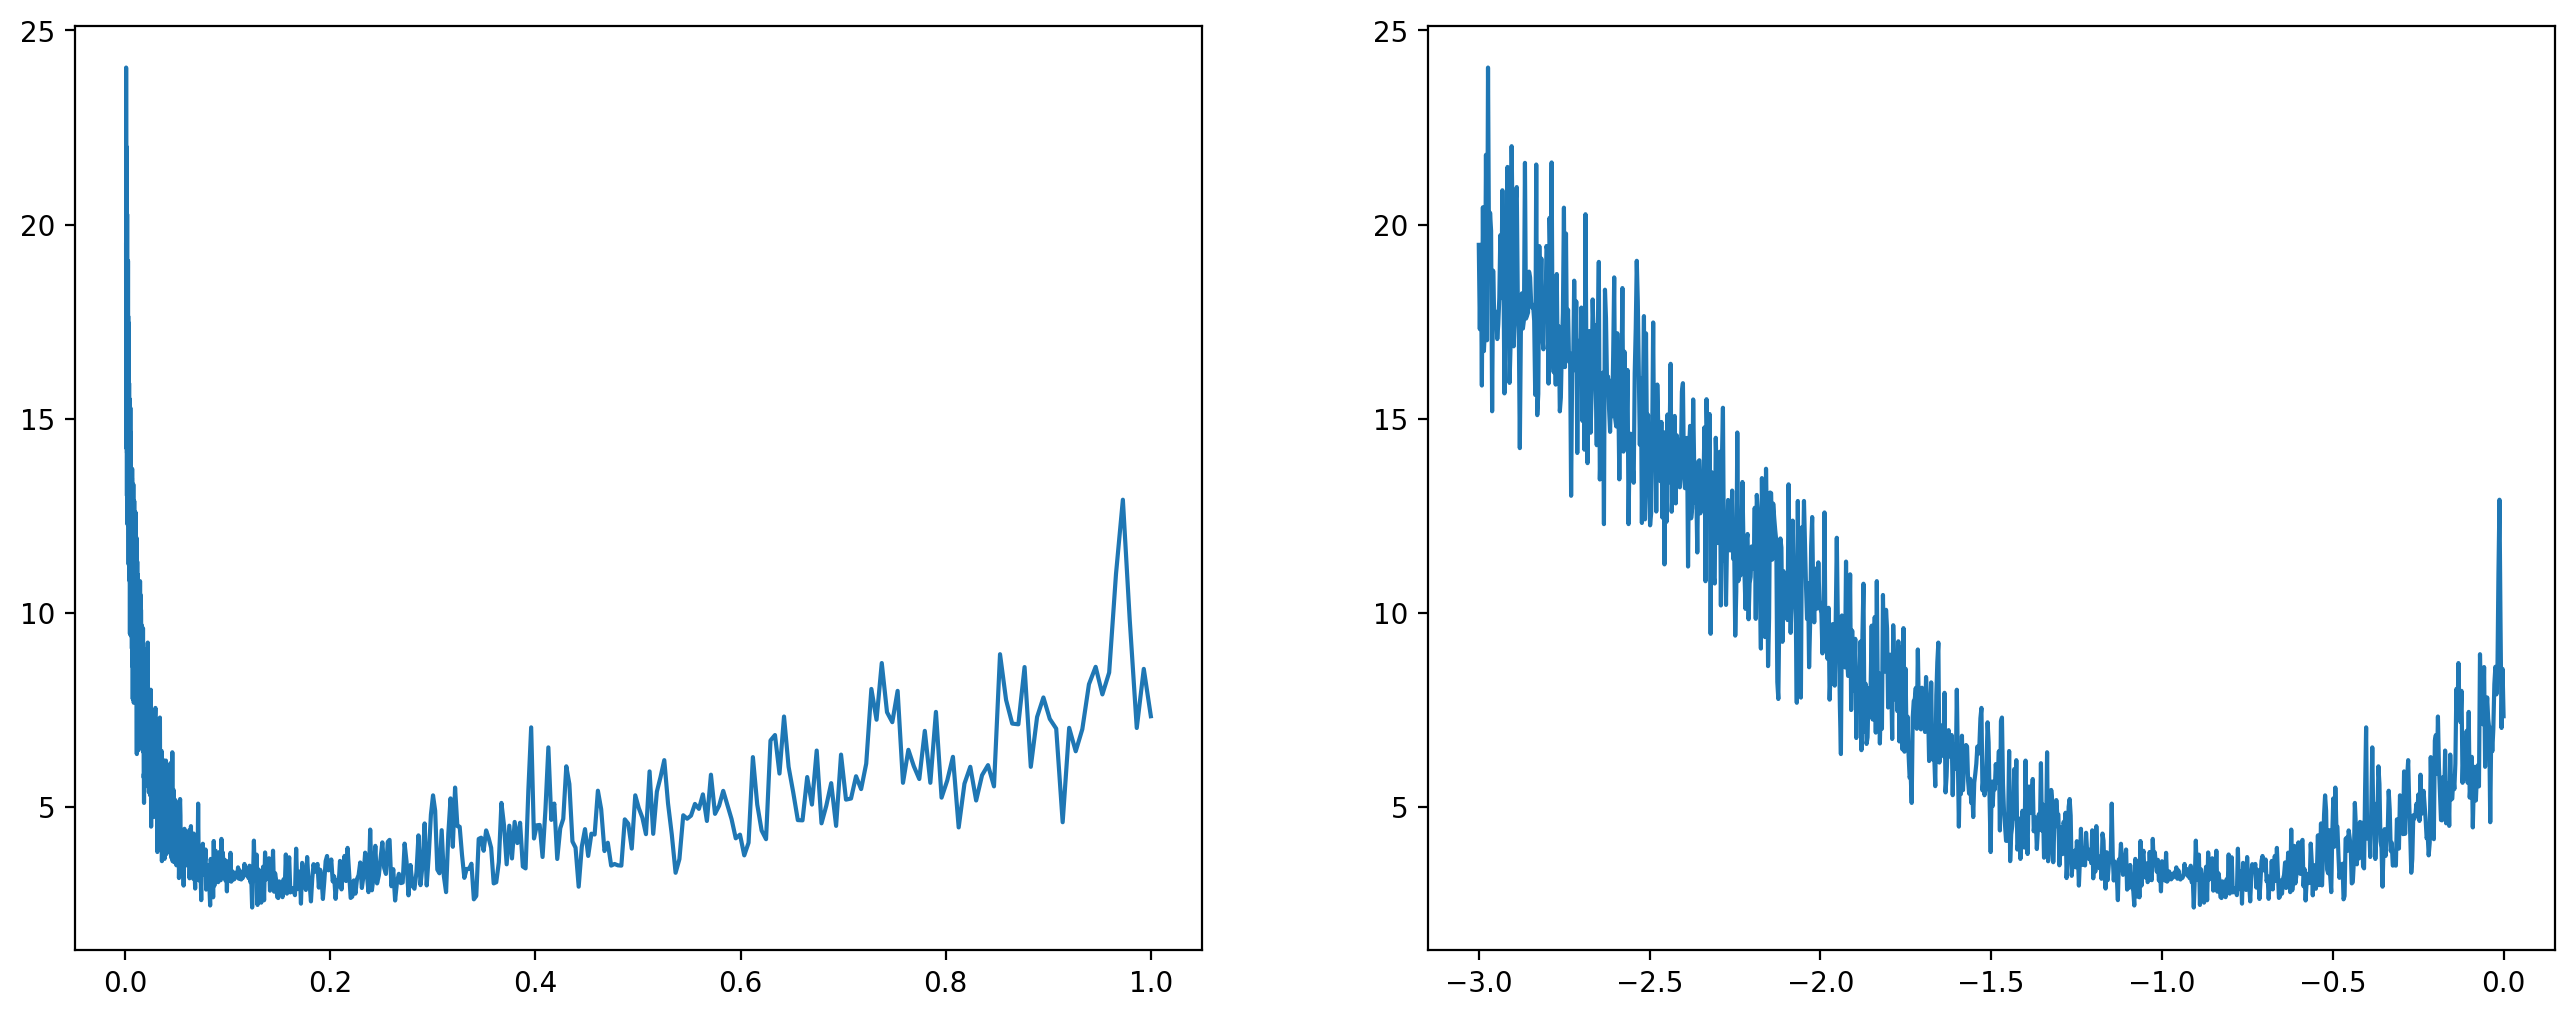

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(lri, lossi)

plt.subplot(1,2,2)
plt.plot(stepi, lossi)
plt.show()

# now based on this we can deduce that our learning rate will be something around 0.1 